In [ ]:
from rag_module.rag import RAG, Embedder
import mlflow
import inspect
import pandas as pd
import os
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# set path to database
os.environ["embedding_path"] = "./embeddings/ELOQ_news_partial_2/"

# load eval data
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

print(f'n queries silver: {len(silver)}')
print(f'n queries gold: {len(gold)}')

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n queries silver: 18820
n queries gold: 216


In [77]:
# add labels to eval data
embedder = Embedder(model_name="all-MiniLM-L6-v2")
database_filenames = set(chunk['filename'] for chunk in embedder.chunkdata)
database_cats = set(x.split('_')[0] for x in database_filenames)

def add_label(df, database_filenames):
    """
    Add 'in_database' and 'label' columns to the ScopeQA dataset.
    - 'in_database': whether the document appears in the known database filenames.
    - 'label':
        - 0: query relates to a document in the database and is answerable
        - 1: query relates to a document in the database but is not answerable
        - 2: query relates to a document not in the database
    """
    df['in_database'] = df['doc_id'].isin(database_filenames)
    
    df['label'] = 2
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'no'), 'label'] = 0
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'yes'), 'label'] = 1

def add_unrelated_label(df, database_cats):
    """
    Add label to indicate if a query is unrelated to the database, based on if the topic is in the database.
    """
    df['category'] = df['doc_id'].apply(lambda x: x.split('_')[0])
    df['unrelated'] = df['category'].apply(lambda x: 1 if x not in database_cats else 0)

def add_answerable_label(df, database_filenames):
    """
    Add label to indicate if a query is answerable, based on if the document is in the database.
    """
    df['answerable'] = df['doc_id'].isin(database_filenames).astype(int)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [78]:
add_label(silver, database_filenames)
add_label(gold, database_filenames)

In [29]:
add_unrelated_label(silver, database_cats)
add_unrelated_label(gold, database_cats)
add_answerable_label(silver, database_filenames)
add_answerable_label(gold, database_filenames)

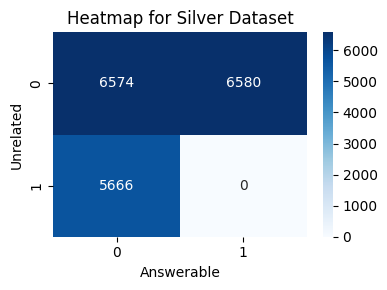

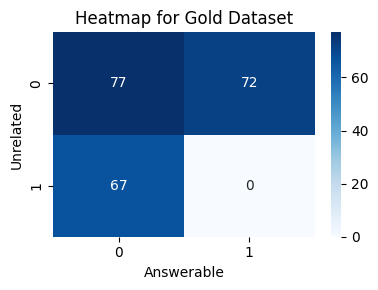

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, title):
    # Create a pivot table for the heatmap
    heatmap_data = df.pivot_table(index='unrelated', columns='answerable', aggfunc='size', fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel('Answerable')
    plt.ylabel('Unrelated')
    plt.tight_layout()
    plt.show()

# Plot heatmaps for silver and gold
plot_heatmap(silver, title="Heatmap for Silver Dataset")
plot_heatmap(gold, title="Heatmap for Gold Dataset")

In [98]:
# Create train and test sets

sample_method = 'balance'
n_train = 450
n_test = 140
label_col = 'label'

def balanced_sample(df, label_col, n_total, random_state=1):
    n_classes = df[label_col].nunique()
    n_per_class = n_total // n_classes
    
    # Initialize an empty DataFrame to store results
    result = pd.DataFrame()
    
    # For each class, sample and append to result
    for label_value, group in df.groupby(label_col):
        sampled = group.sample(n=min(n_per_class, len(group)), random_state=random_state)
        result = pd.concat([result, sampled])
    
    # Reset index without shuffling
    result = result.reset_index(drop=True)
    
    return result

if sample_method == 'balance':
    trainset = balanced_sample(silver, label_col, n_total=n_train)
    testset = balanced_sample(gold, label_col, n_total=n_test)
elif sample_method == 'sample':
    trainset = silver.sample(n=n_train, random_state=1).reset_index(drop=True)
    testset = gold.sample(n=n_test, random_state=1).reset_index(drop=True)
else:
    trainset = silver.copy()
    testset = gold.copy()

print('trainset:')
print(trainset[label_col].value_counts(), '\n')

print('testset:')
print(testset[label_col].value_counts())

trainset:
label
0    150
1    150
2    150
Name: count, dtype: int64 

testset:
label
2    46
1    37
0    35
Name: count, dtype: int64


In [35]:
# set RAG models
rags = [
    {
        "model": RAG(reranker_name="flashrank", retrieve_top_k=10),
        "name": "topk10"
    }
]

Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


In [136]:
def similarity_scores(rag, df):
    "add scores for the closest chunk to each question"
    # check if column already exists
    if not 'top_sparse_score' in df.columns:
        df['top_sparse_score'] = df['question'].apply(lambda q: rag.embedder.search_bm25(q, top_k=1)[0][0])

    if not 'top_dense_score' in df.columns:
        df['top_dense_score'] = df['question'].apply(lambda q: rag.embedder.search(q, top_k=1)[0][0][0])

def reranker_score(rag, df):
    top_ranked = df['question'].apply(lambda q: rag.retrieve(q)[0])
    df['top_reranker_doc'] = top_ranked.apply(lambda x: x['filename'])
    df['top_reranker_score'] = top_ranked.apply(lambda x: x['score'])

def train_model(df, features, label, model):
    X = df[features].values
    y = df[label].values
    model.fit(X, y)
    return model

def log_constructor_params(instance, cls):
    sig = inspect.signature(cls.__init__)
    bound_args = sig.bind_partial()
    bound_args.apply_defaults()
    all_params = bound_args.arguments

    # Exclude 'self'
    all_params = {k: v for k, v in all_params.items() if k != 'self'}

    # Now get the actual values from the instance if they've changed
    for param in all_params:
        try:
            value = getattr(instance, param)
        except AttributeError:
            value = all_params[param]
        mlflow.log_param(param, str(value))

In [99]:
similarity_scores(rags[0]['model'], trainset)
similarity_scores(rags[0]['model'], testset)

Batches: 100%|██████████| 1/1 [00:00<00:00, 100.45it/s]


In [113]:
def compute_z_score_and_p_value(value, mean, std, onetailed=True):
    """Compute the z-score and p-value for a given value."""
    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-score.")

    z = (value - mean) / std
    if onetailed:
        p = 1 - norm.cdf(z)
    else:
        p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

def apply_z_test_to_dataframe(df, reference_series, column, onetailed=True, alpha=0.1):
    """Apply z-test to a DataFrame column against a reference distribution."""
    mean = reference_series.mean()
    std = reference_series.std(ddof=1)

    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-scores.")

    results = df[column].apply(lambda x: compute_z_score_and_p_value(x, mean, std, onetailed))
    df['z_score'] = results.apply(lambda x: x[0])
    df['p_value'] = results.apply(lambda x: x[1])
    df['OOS'] = df['p_value'] < alpha
    df['OOS'] = df['OOS'].astype(int)
    return df

In [ ]:
reference_scores = trainset[trainset['unrelated'] == 0]['top_dense_score']

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []

alphas = [0.2, 0.1, 0.05, 0.01]

# Iterate over alphas and compute metrics
for alpha in alphas:
    testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
    accuracy = accuracy_score(testset['OOS'], testset['unrelated'])
    precision = precision_score(testset['OOS'], testset['unrelated'], average='weighted')
    recall = recall_score(testset['OOS'], testset['unrelated'], average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

# Display the table
if True:
    print(results_df)
else:
    print(results_df.to_latex(index=False, float_format="%.4f"))

   Alpha  Accuracy  Precision    Recall
0   0.20  0.813559   0.828319  0.813559
1   0.10  0.889831   0.887754  0.889831
2   0.05  0.847458   0.924661  0.847458
3   0.01  0.838983   1.000000  0.838983


c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
alpha = 0.1

trainset = apply_z_test_to_dataframe(trainset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)
testset = apply_z_test_to_dataframe(testset, reference_series=reference_scores, column='top_dense_score', alpha=alpha)

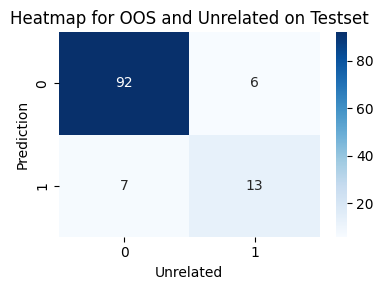

In [133]:
# Create a pivot table for the heatmap
heatmap_data = testset.pivot_table(index='OOS', columns='unrelated', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap for OOS and Unrelated on Testset")
plt.xlabel('Unrelated')
plt.ylabel('Prediction')
plt.tight_layout()
plt.show()

In [134]:
# configure training

models = [
        {
            "model": LogisticRegression(
                random_state=1
            ),
            "name": "logreg"
        },
        {
            "model": LogisticRegression(
                multi_class='ovr',
                solver='lbfgs',
                max_iter=1000,
                random_state=1
            ),
            "name": "logreg_ovr"
        },
        {
            "model": LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                random_state=1
            ),
            "name": "logreg_softmax"
        },
        {
            "model": DecisionTreeClassifier(
                random_state=1,
                max_depth=5
            ),
            "name": "decision_tree"
        }
    ]
models = [models[0]]

features = ['top_sparse_score', 'top_dense_score', 'z_score']

label = 'answerable'

In [137]:
# set mlflow experiment
mlflow.set_experiment("eval_scope_models")

for rag in rags:  
    for model in models:
        run_name = f"{rag['name']}_{model['name']}"
        with mlflow.start_run(run_name=run_name) as run:
    
            # train model
            model = train_model(trainset, features=features, label=label, model=model['model'])

            # predict on testset
            testset['logreg_prediction'] = model.predict(testset[features].values) 
            testset['logreg_probability'] = model.predict_proba(testset[features].values)[:, 1]

            # get metrics
            retrieve_accuracy = 999
            if 'top_reranker_doc' in testset.columns:
                retrieve_accuracy = accuracy_score(testset['doc_id'], testset['top_reranker_doc'])
            accuracy = accuracy_score(testset[label], testset['logreg_prediction'])
            f1 = f1_score(testset[label], testset['logreg_prediction'], average='weighted')
            precision = precision_score(testset[label], testset['logreg_prediction'], average='weighted')
            recall = recall_score(testset[label], testset['logreg_prediction'], average='weighted')

            # log to mlflow
            #log_constructor_params(rag['model'], rag['model'].__class__.__bases__[0])
            log_constructor_params(rag['model'], rag['model'].__class__)
            mlflow.log_param("model_name", rag["name"])
            mlflow.log_param("features", str(features))
            mlflow.log_param("trainset_size", len(trainset))
            mlflow.log_param("testset_size", len(testset))
            mlflow.log_param("n_labels", len(testset[label].unique()))

            mlflow.sklearn.log_model(model, artifact_path="model")

            mlflow.log_metric("retrieve_accuracy", retrieve_accuracy)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score_weighted", f1)
            mlflow.log_metric("precision_weighted", precision)
            mlflow.log_metric("recall_weighted", recall)

2025/04/29 15:28:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [150]:
testset['final_prediction'] = 0
testset.loc[testset['logreg_prediction'] == 0, 'final_prediction'] = 1 # unanswerable
testset.loc[testset['OOS'] == 1, 'final_prediction'] = 2 # unrelated

In [153]:
testset.drop(['question', 'answer'], axis=1).sample(15)

,doc_id,q_id,llm_confusion_label,human_confusion_label,llm_defusion_label,human_defusion_label,category,unrelated,unanswerable,answerable,in_database,label,top_sparse_score,top_dense_score,z_score,p_value,OOS,logreg_prediction,logreg_probability,final_prediction
2,travel_92,travel_92_0_1,no,no,NaN,NaN,travel,0,1,1,True,0,65.259021,0.498709,-1.942612,0.973968,0,1,0.996724,0
116,news_177,news_177_1_2,yes,yes,no,no,news,0,0,0,False,2,19.695869,1.214134,0.896594,0.184968,0,0,0.327507,1
88,tech_111,tech_111_1_5,yes,yes,no,no,tech,0,0,0,False,2,25.336481,1.348876,1.431329,0.076168,1,0,0.331730,2
100,business_177,business_177_1_4,yes,yes,no,no,business,0,0,0,False,2,27.865814,1.413462,1.687642,0.045740,1,0,0.330415,2
56,tech_152,tech_152_1_3,yes,no,no,NaN,tech,0,1,1,True,1,33.882372,0.860287,-0.507667,0.694157,0,1,0.850868,0
55,news_72,news_72_1_5,yes,yes,no,no,news,0,1,1,True,1,32.064832,1.235846,0.982763,0.162862,0,1,0.568551,0
115,news_29,news_29_0_3,no,no,NaN,NaN,news,0,0,0,False,2,25.440812,1.268742,1.113310,0.132788,0,0,0.398380,1
117,music_155,music_155_1_4,yes,yes,no,no,music,1,0,0,False,2,30.749514,1.221087,0.924191,0.177694,0,1,0.553162,0
74,science_125,science_125_0_2,no,no,NaN,NaN,science,0,0,0,False,2,31.657150,1.468165,1.904733,0.028407,1,0,0.361573,2
110,business_41,business_41_0_5,no,no,NaN,NaN,business,0,0,0,False,2,23.402864,1.126344,0.548198,0.291778,0,0,0.476839,1


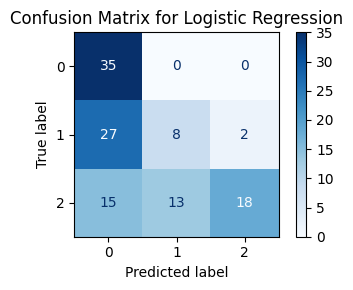

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract the true labels and predictions
y_true = testset['label']
y_pred = testset['final_prediction']

# Get the unique class labels (in case they're not 0, 1, 2...)
classes = np.unique(np.concatenate([y_true, y_pred]))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with proper labels
fig, ax = plt.subplots(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax)

plt.title('Confusion Matrix for Logistic Regression')
plt.grid(False)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

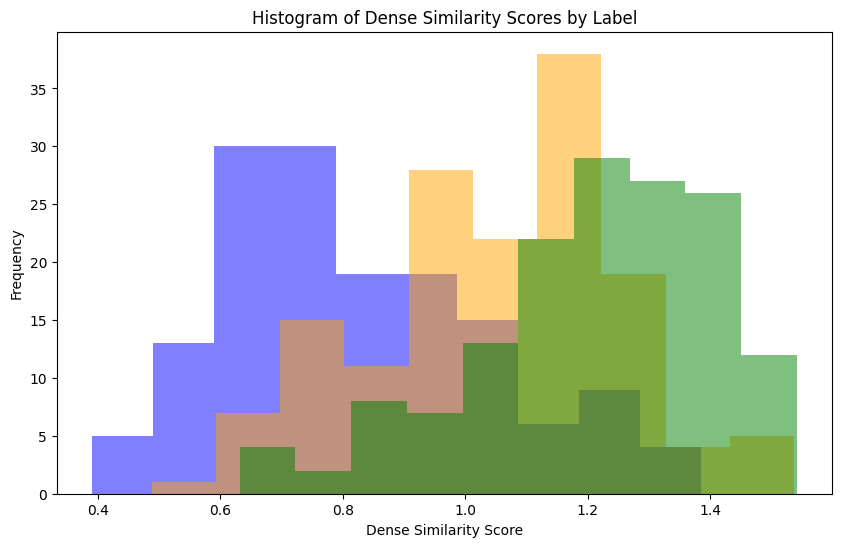

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# histogram of dense similarity of each label
classes = np.unique(trainset['label'])
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(10, 6))
for i, label in enumerate(classes):
    plt.hist(trainset[trainset['label'] == label]['top_dense_score'], bins=10, alpha=0.5, label=f'label {label}', color=colors[i])
plt.title('Histogram of Dense Similarity Scores by Label')
plt.xlabel('Dense Similarity Score')
plt.ylabel('Frequency')

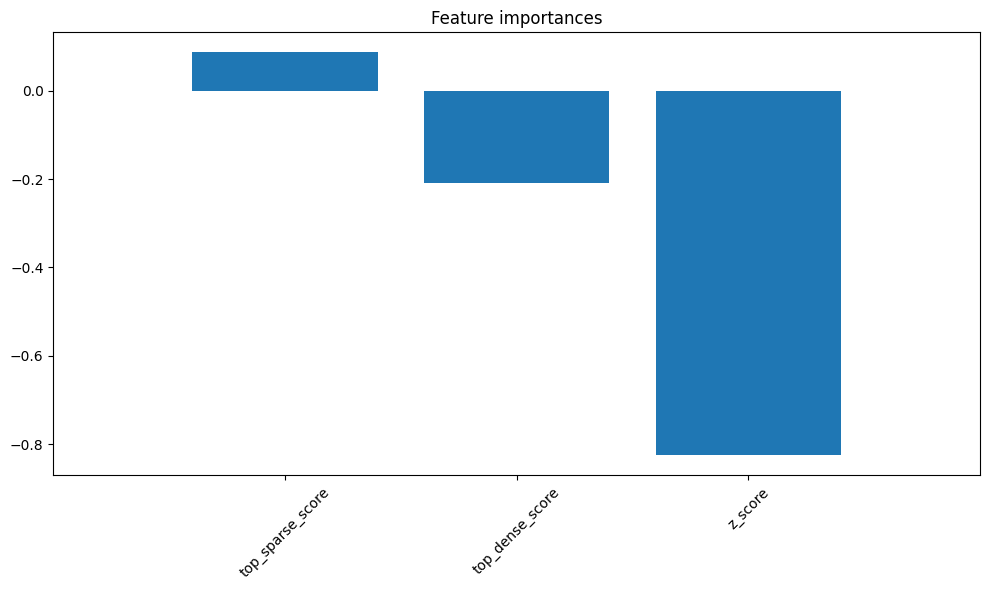

In [157]:
# feature importance
importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.coef_[0]
indices = np.argsort(importances)[::-1]
feature_names = features
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45)
plt.xlim([-1, len(importances)])
plt.tight_layout()

In [70]:
# Get the coefficients from the trained model
coefficients = model.coef_[0]

# Combine into a DataFrame for readability
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance)

              feature  coefficient
0  top_reranker_score     0.627164
2     top_dense_score    -0.278433
1    top_sparse_score     0.123222


In [84]:
import pickle

# predict from logreg model
modelpath = os.getenv("embedding_path") + 'model.pkl'
with open(modelpath, 'rb') as f:
    model = pickle.load(f)

# Predict using the model
predictions = model.predict(np.array([0.89, 0.66, 0.66]).reshape(1, -1))

# Output predictions
print("Predictions:", predictions)


Predictions: [1]


In [86]:
model

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=1)

# User testing

In [ ]:
# load data
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

In [ ]:
response = rag.query("Write a short paragraph about the New York Yankees.")

In [ ]:
# logging to Azure Blob Storage

import json
from datetime import datetime
from azure.storage.blob import BlobServiceClient

connection_string = os.getenv("AZURE_CONNECTION_STRING", "")
container_name = "raglog"

def log_dict_to_blob(data: dict, container_name: str, connection_string: str, blob_name: str = None):
    """
    Upload a dictionary as a JSON file to an Azure Blob Storage container.
    """
    if not blob_name:
        blob_name = f"log_{datetime.utcnow().isoformat()}.json"

    json_data = json.dumps(data, indent=2)

    # Connect to Blob service
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    container_client = blob_service_client.get_container_client(container_name)

    # Upload the JSON string as a blob
    container_client.upload_blob(name=blob_name, data=json_data, overwrite=True)

    print(f"Uploaded to Azure Blob: {container_name}/{blob_name}")

log_dict_to_blob(data=response, container_name=container_name, connection_string=connection_string, blob_name="test.json")
